<a href="https://colab.research.google.com/github/AkindeKadjo/food_sales_predictions/blob/main/000_Final_Cleaned_Project_1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Akinde Kadjo

Date: 09/22/2022

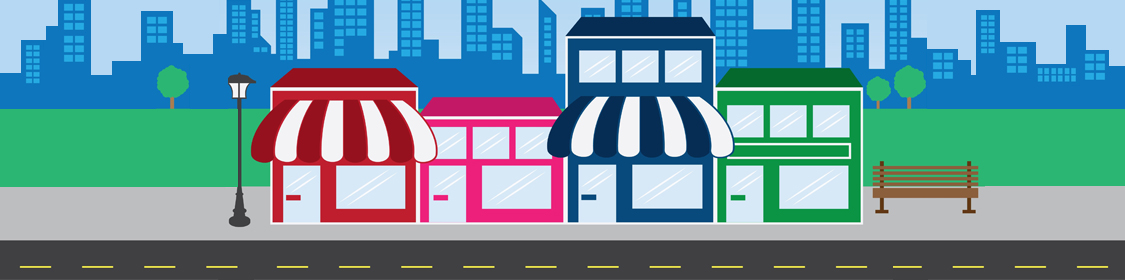

Image Taken from [displays2go.com](https://www.displays2go.com/Industry/Retail-Fixtures-Selling-Merchandise-Brick-Mortar-Stores-67)

>>**The goal of this project is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales. The data was provided from a Class Assignment**



---



---



#Library Imports and Data Loading

In [1]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
set_config(display='diagram')

In [2]:
#Loading the data
filename = '/content/drive/MyDrive/Coding Dojo/05 Week 5 Intro to ML/sales_predictions.csv'
Original_df = pd.read_csv(filename)
# keeping a copy of the df as a safety net
df = Original_df.copy()
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


A quick check for the data info is done to have an overall idea of the loaded data set

In [3]:
#checking for data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#Data Cleaning

##Checking for missing values and duplicates

In [4]:
#checking for duplicate and deleting them
df.duplicated().sum()
df = df.drop_duplicates()

In [5]:
#check for missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

The cell above shows that there are indeed missing values. These missing values won't be handled right now before splitting the data for machine learning as to avoid data leakage

##Addressing Data Inconcistencies

In [6]:
#Identifying and addressing any inconsistencies in categorical values
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')

- Column= Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



- Column= Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



- Column= Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



- Column= Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    9

In [7]:
#fix the inconcistency when it comes to Item fat content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [8]:
#checking for significant outliers for the numerical data
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


All the inconsistencies have been addressed and there is no significant outliers from the numerical data.

#Assessing factors affecting outlet sales through graphs

##Numerical columns

###Heatmap

A heat map is a great way to assess the correlations of each numerical column from one to another.

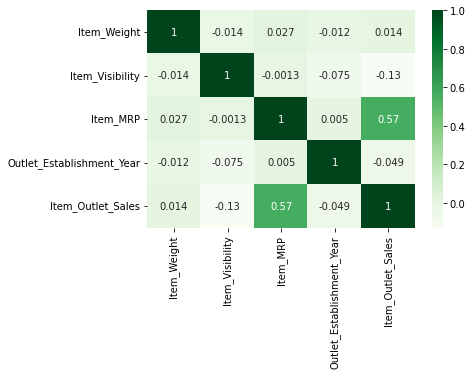

In [9]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot =True)

For numerical columns, based on the heatmap we can deduce that there is a positive corelation between the item MRP and the Item Outlet sales. Item visibility comes in second in terms of correlation. Not much can be said for the rest of the other categories.

###Histogram

An histogram gives us an overview of the distributions of various features such outlet sales, item MRPs and item visibilities as in our dataset.

Text(0, 0.5, 'Counts')

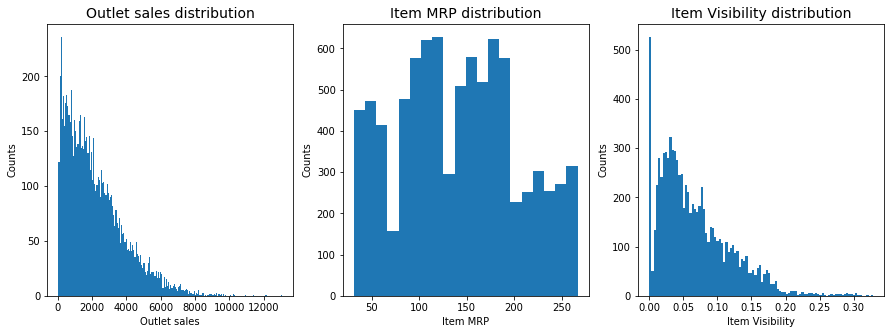

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5));
axes[0].hist(df['Item_Outlet_Sales'], bins = 200)
axes[0].set_title('Outlet sales distribution', fontsize = 14)
axes[0].set_xlabel('Outlet sales')
axes[0].set_ylabel('Counts')

axes[1].hist(df['Item_MRP'], bins = 20)
axes[1].set_title('Item MRP distribution', fontsize = 14)
axes[1].set_xlabel('Item MRP')
axes[1].set_ylabel('Counts')

axes[2].hist(df['Item_Visibility'], bins = 100)
axes[2].set_title('Item Visibility distribution', fontsize = 14)
axes[2].set_xlabel('Item Visibility')
axes[2].set_ylabel('Counts')

From the results above it seems as thought: items that bring in a lot of sales are a lot less than items that don't. The item MRP is somehow evenly distributed. Also, a lot of items tends to have lower visibility.

##Categorical columns

From a quick glance at the data, we  can assess that columns such as Item_Identifier and	Outlet_Identifier have no impact on the outlet sales because they are just identifers.

Which leave us with Item_Fat_Content, Item_Type, Outlet_Size,Outlet_Location_Type	and Outlet_Type. Barplots and Boxplots are often good indicators of factors affecting an outcome when it comes to categorical data.

###Barplots

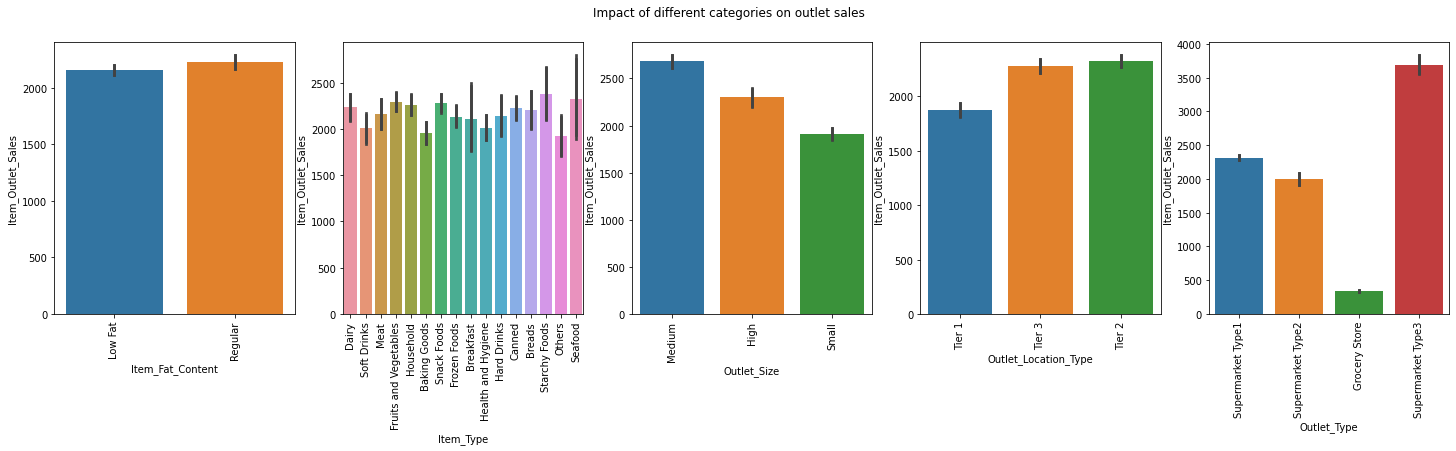

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Impact of different categories on outlet sales')
sns.barplot(ax=axes[0], data=df, x='Item_Fat_Content', y='Item_Outlet_Sales')
sns.barplot(ax=axes[1], data=df, x='Item_Type', y='Item_Outlet_Sales')
sns.barplot(ax=axes[2], data=df, x='Outlet_Size', y='Item_Outlet_Sales')
sns.barplot(ax=axes[3], data=df, x='Outlet_Location_Type', y='Item_Outlet_Sales')
sns.barplot(ax=axes[4], data=df, x='Outlet_Type', y='Item_Outlet_Sales')
ax1 = sns.barplot(ax=axes[0], data=df, x='Item_Fat_Content', y='Item_Outlet_Sales')
ax2 = sns.barplot(ax=axes[1], data=df, x='Item_Type', y='Item_Outlet_Sales')
ax3 = sns.barplot(ax=axes[2], data=df, x='Outlet_Size', y='Item_Outlet_Sales')
ax4 = sns.barplot(ax=axes[3], data=df, x='Outlet_Location_Type', y='Item_Outlet_Sales')
ax5 = sns.barplot(ax=axes[4], data=df, x='Outlet_Type', y='Item_Outlet_Sales')
ax1.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelrotation=90)
ax3.tick_params(axis='x', labelrotation=90)
ax4.tick_params(axis='x', labelrotation=90)
ax5.tick_params(axis='x', labelrotation=90)

Based on the barplots above, the following columns: Item_Type, Item_MRP, Outlet_Size, Outlet_Location_Type, and Outlet_Type have unique values that contribute differently to the outlet sales and therefore may be good prediction features for machine learning.

On the other end, Item_Fat content doesn't seem to play much of a role in the outlet sales, both the low fat items as well as the regular items contribute about equally.

###Boxplots

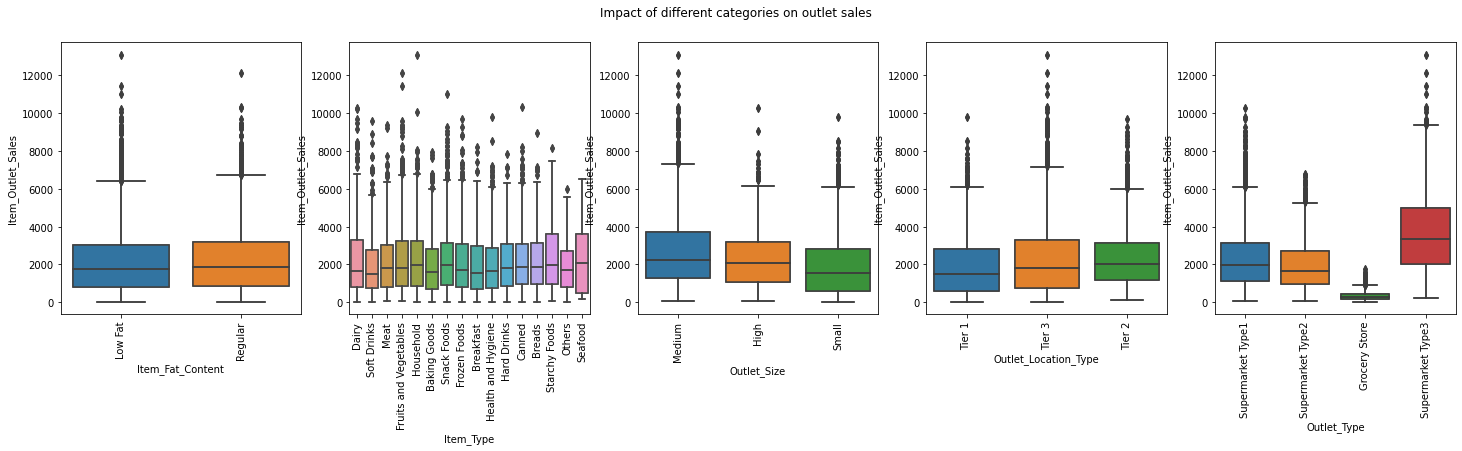

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle('Impact of different categories on outlet sales')
sns.boxplot(ax=axes[0], data=df, x='Item_Fat_Content', y='Item_Outlet_Sales')
sns.boxplot(ax=axes[1], data=df, x='Item_Type', y='Item_Outlet_Sales')
sns.boxplot(ax=axes[2], data=df, x='Outlet_Size', y='Item_Outlet_Sales')
sns.boxplot(ax=axes[3], data=df, x='Outlet_Location_Type', y='Item_Outlet_Sales')
sns.boxplot(ax=axes[4], data=df, x='Outlet_Type', y='Item_Outlet_Sales')
ax1 = sns.boxplot(ax=axes[0], data=df, x='Item_Fat_Content', y='Item_Outlet_Sales')
ax2 = sns.boxplot(ax=axes[1], data=df, x='Item_Type', y='Item_Outlet_Sales')
ax3 = sns.boxplot(ax=axes[2], data=df, x='Outlet_Size', y='Item_Outlet_Sales')
ax4 = sns.boxplot(ax=axes[3], data=df, x='Outlet_Location_Type', y='Item_Outlet_Sales')
ax5 = sns.boxplot(ax=axes[4], data=df, x='Outlet_Type', y='Item_Outlet_Sales')
ax1.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelrotation=90)
ax3.tick_params(axis='x', labelrotation=90)
ax4.tick_params(axis='x', labelrotation=90)
ax5.tick_params(axis='x', labelrotation=90)

The boxplot above, confirms the assessments made previously with the barplots. The additional benfits of the boxplots is the overview of the statistical distribution for each item.

Therefore, for the categorical columns, the feature columns will be: Item_Type, Item_MRP, Outlet_Size, Outlet_Location_Type, and Outlet_Type.

#Outlet Sales Predictions with Machine Learning

**The goal of this step is to help the retailer by using machine learning to make predictions about future sales based on the data provided.**

##Data Splitting and Preprocessing

###Data Splitting

The target (y) column has been predetermined by the goal of the project which happens to be Outlet sales.

From the previous assessements made above the features (X) columns have been chosen.

In [13]:
#setting y as a target column
y = df['Item_Outlet_Sales']
#setting X as the feature data, decision made based on prior analysis results from above plots
X = df[['Item_Visibility','Item_Type','Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']]
X.head()

,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1
1,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2
2,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1
3,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store
4,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1


Performing a train test split, here the random state of 42 is chosen for concistency

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

###Preprocessing

Creating a preprocessing object to prepare the dataset for Machine Learning

In [15]:
#quick check of the data type
X.dtypes

Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
dtype: object

>Numerical columns are: Item_Visibility, Item_MRP

>Nominal columns are: Item_Type, Outlet_Type

>Ordinal columns are: Outlet_Size, Outlet_Location_Type

Here, the imputation of missing values occurs  after the train test split using SimpleImputer to prevent data leakage. 

In [16]:
#instantiating the StandardScaler, OneHotEncoder and Imputers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#I'll use 'mean' for numerical columns ( they're float) and 'most frequent' for both nominal and ordinal columns
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

# Instantiating the OrdinalEncoder 
  # Creating a list of ordinal labels in acsending order
Size_labels = ['Small','Medium','High']
Location_labels = ['Tier 3','Tier 2','Tier 1']
  #combining the ordered list in the order that the columns appear
ordered_labels = [Size_labels, Location_labels]
ordinal = OrdinalEncoder(categories = ordered_labels)

Creating a Pipeline Numeric Data and a Pipeline for Categorical Data

In [17]:
# Setting up the pipelines for the numeric and categorical data
num_pipeline = make_pipeline(mean_imputer, scaler)
ord_pipeline = make_pipeline(freq_imputer, ordinal)
nom_pipeline = make_pipeline(freq_imputer, ohe)

Creating Tuples to Pair Pipelines with Columns

In [18]:
# Creating column lists for objects and a number selector
ordinal_cols = ['Outlet_Size', 'Outlet_Location_Type']
nominal_cols = ['Item_Type', 'Outlet_Type']
num_selector = make_column_selector(dtype_include='number')

# Setting up the tuples to pair the processors with the make column selectors
numeric_tuple = (num_pipeline, num_selector)
ordinal_tuple = (ord_pipeline, ordinal_cols)
nominal_tuple = (nom_pipeline, nominal_cols)

Creating Column Transformer and fitting it on the Training Data

In [19]:
# Instantiating the make column transformer
preprocessor = make_column_transformer(ordinal_tuple, numeric_tuple, nominal_tuple, remainder='drop')
# Fitting the column transformer on the X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '3',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '1']]))]),
                                 ['Outlet_Size', 'Outlet_Location_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4ad2a86d0>),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Type', 'Outlet_Type'])])

Transforming Both Training and Testing Data

In [20]:
# Transforming the X_train and the X_test
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

Checking the result

In [21]:
#showing the data in pandas dataframe 
X_train_transformed_df = pd.DataFrame(X_train_transformed)
X_train_transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.0,0.0,-0.712775,1.828109,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,-1.291052,0.603369,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,2.0,1.813319,0.244541,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,-1.004931,-0.952591,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,-0.965484,-0.336460,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##Prediction Models

> I'm creating a function that will output the metrics for my model prediction evaluation

In [46]:
def eval_regression(true, pred):
  """Takes true and predicted values (arrays) and prints RMSE and R2"""
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse).round(0)
  r2 = r2_score(true, pred).round(4)
  print(f' RMSE:  {rmse},\n R^2: {r2} ')

###Linear Regression

My first model of choice is Linear regression due to the fact that it is the most common used algorithm and is known to be quite accurate in some cases.

In [23]:
# Instantiating linear regression
lin_reg = LinearRegression()
#Creating a model pipeline with the preprocessor first and linear regression model last
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)
#Fitting the modeling pipeline on the training data
lin_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '3',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '1']]))]),
                                                  ['Outlet_Size',
                                                   'Outlet_Location_Type']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4ad2a86d0>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Type',
                                                   'Outlet_Type'])])),
                ('linearregression', LinearRegression())])

In [24]:
#Getting the predicted values
train_lin_reg_pred = lin_reg_pipe.predict(X_train)
test_lin_reg_pred = lin_reg_pipe.predict(X_test)

In [47]:
# MAE, MSE, RMSE and R2 for the train based on the linear regression model
eval_regression(y_train, train_lin_reg_pred)

 RMSE:  1141.0,
 R^2: 0.5602 


In [48]:
# MAE, MSE, RMSE and R2 for the test based on the linear regression model
eval_regression(y_test, test_lin_reg_pred)

 RMSE:  1094.0,
 R^2: 0.5663 


The somewhat low R2 of about 0.56 for both the training data set and the RMSE that points to the fact that on average I'm off in prediction about 1000, seems to indicate that the model is not quite accurate. I'll have to try another model 

###Random Forest

>The choice to proceed with the Random Forest approach is based on prior analyses made in the past where Random forest often outperformed both Decision Tree and Bagging Tree algorithms for data sets containg a mixture of numerical, ordinal and nominal data.

In [27]:
#instantiating random forest
rf = RandomForestRegressor(random_state = 42)
#Creating a model pipeline with the preprocessor first and random forest model last
rf_pipe = make_pipeline(preprocessor, rf)
#Fitting the modeling pipeline on the training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '3',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '1']]))]),
                                                  ['Outlet_Size',
                                                   'Outlet_Location_Type']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer...
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4ad2a86d0>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Type',
                                                   'Outlet_Type'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [28]:
#Getting the predicted values
train_rf_pred = rf_pipe.predict(X_train)
test_rf_pred = rf_pipe.predict(X_test)

In [49]:
# MAE, MSE, RMSE and R2 for the train based on the Random forest model
eval_regression(y_train, train_rf_pred)

 RMSE:  432.0,
 R^2: 0.937 


In [50]:
# MAE, MSE, RMSE and R2 for the test based on the Random forest model
eval_regression(y_test, test_rf_pred)

 RMSE:  1110.0,
 R^2: 0.5534 


The training set did perform well with an R2 above 0.9 and a RMSE near 400, however the test set has a much lower R2 of 0.5 and a much higher RMSE. Based on the difference of results of RMSE and the R2 for the training set versus the test set, so a model tuning is needed.

####Model Tuning

>Tuning max_depth

In [31]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

44

In [32]:
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   rf_model = RandomForestRegressor(max_depth=depth)
   rf_pipe_model = make_pipeline(preprocessor, rf_model)
   rf_pipe_model.fit(X_train, y_train)
   scores.loc[depth, 'Train Score'] = rf_pipe_model.score(X_train, y_train)
   scores.loc[depth, 'Test Score'] = rf_pipe_model.score(X_test, y_test)

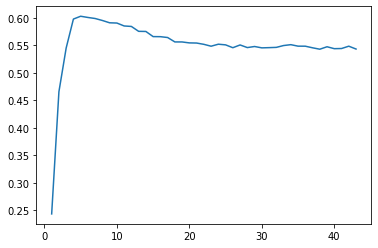

In [33]:
plt.plot(scores['Test Score'])

In [34]:
# sorting the dataframe by test scores and printing the best depth
best_depth = scores.sort_values(by='Test Score', ascending=False).index[0]
best_depth

5

The best max depth is 5 so I'll now move on to tuning the n_estimators

>Tuning n_estimators

In [51]:
n_ests = [10, 50, 75, 100, 125, 150, 175, 200, 225, 250, 500, 750, 1000]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
   rf_model = RandomForestRegressor(max_depth=best_depth, n_estimators=n)
   rf_pipe_model = make_pipeline(preprocessor, rf_model)
   rf_pipe_model.fit(X_train, y_train)
   scores2.loc[n, 'Train Score'] = rf_pipe_model.score(X_train, y_train)
   scores2.loc[n, 'Test Score'] = rf_pipe_model.score(X_test, y_test)

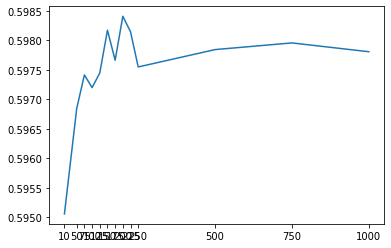

In [36]:
plt.plot(scores2['Test Score'])
plt.xticks(n_ests);

In [37]:
# sorting the dataframe by test scores and printing the best n estimator
best_n_estimator = scores2.sort_values(by='Test Score', ascending=False).index[0]
best_n_estimator

200

So the best n-estimator is 200

####Optimized Random forest

In [53]:
#instantiating random forest with the optimal conditions
rf_maxbest_nbest = RandomForestRegressor(max_depth=best_depth, n_estimators=best_n_estimator,random_state = 42)
#Creating a model pipeline with the preprocessor first and random forest model last
rf_maxbest_nbest_pipe = make_pipeline(preprocessor, rf_maxbest_nbest)
#Fitting the modeling pipeline on the training data
rf_maxbest_nbest_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '3',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '1']]))]),
                                                  ['Outlet_Size',
                                                   'Outlet_Location_Type']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb4ad2a86d0>),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Item_Type',
                                                   'Outlet_Type'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_estimators=200,
                                       random_state=42))])

In [54]:
train_rf_pred_maxbest_nbest = rf_maxbest_nbest_pipe.predict(X_train)
test_rf_pred_maxbest_nbest = rf_maxbest_nbest_pipe.predict(X_test)

In [55]:
# RMSE and R2 for the train based on the optimal Random forest model
eval_regression(y_train, train_rf_pred_maxbest_nbest)

 RMSE:  1074.0,
 R^2: 0.6103 


In [56]:
# RMSE and R2 for the test based on the optimal Random forest model
eval_regression(y_test, test_rf_pred_maxbest_nbest)

 RMSE:  1047.0,
 R^2: 0.6029 


There is a slight improvement in the test metrics after tuning, now let's put all of the results side by side and do a final assessment

###Comparing all of the results from each optimized models

In [57]:
#creating a data frame output of the metrics
def res_regression(true, pred):
  """Takes true and predicted values (arrays) and prints RMSE and R2"""
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse).round(0)
  r2 = r2_score(true, pred).round(4)
  res_df = pd.DataFrame([rmse,r2])
  return res_df

In [58]:
#putting all of the metrics results for the test results within the same dataframe for comparison
test_list = [test_lin_reg_pred , test_rf_pred_maxbest_nbest]
metrics_list = ['RMSE','R2']
tabled_test_results_df = pd.DataFrame(metrics_list)
c=1
for i in test_list:
   c=c+1
   df_i= res_regression(y_test, i)
   tabled_test_results_df.loc[:, c] = df_i
tabled_test_results_df.columns = [ 'Metrics', 'Linear_Regression', 'Optimal_Random_Forest']
tabled_test_results_df

,Metrics,Linear_Regression,Optimal_Random_Forest
0,RMSE,1094.0000,1047.0000
1,R2,0.5663,0.6029


#Conclusion

Overall a moderate prediction was achived using the random forest model. Potentially, there are unknown features that may contribute to improve the model but that have not been reported.